In [2]:
import jax.numpy as jnp
from jax import random, lax, nn, jit, vmap, value_and_grad, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import optax

from quantum_error_correction_code import surface_code, QEC
from neural_network import CNN, MLP

In [3]:
BATCH_SIZE = 2
TRAINING_BATCHES = 50_000

LEARNING_RATE = 1E-3
TRANSITION_STEP = 5_000
DECAY_RATE = 0.9

# Number of filters, Kernal size, Stride
CONV_LAYERS = [(5,2,1), (10,2,1)]
FC_LAYERS = [25, 2]

SEED = 69

CODE_DISTANCE = 3

# CODE_DEFORMATION = jnp.array([0,0,0,0,0,0,0,0,0])
# CODE_DEFORMATION = jnp.array([3,0,3,0,3,0,3,0,3])
CODE_DEFORMATION = jnp.array([2,0,2,3,2,3,2,0,2])
# CODE_DEFORMATION = jnp.array([2,3,2,0,2,0,2,3,2])
# CODE_DEFORMATION = jnp.array([2,2,2,2,2,2,2,2,2])

# px, pz = .01, .01
# ERROR_PROBS = jnp.array([px*(1-pz),px*pz,(1-px)*pz])
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])
# ERROR_PROBS = jnp.array([.01,.01,.01])

In [4]:
def train(
    random_seed: int,
    code: QEC,
    parity_info: tuple[jnp.ndarray],
    probabilities: jnp.ndarray,
    optimizer: optax.GradientTransformation,
    model: CNN
):
    @jit
    def loss_fn(
        model_params,
        x: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
        """
        return optax.sigmoid_binary_cross_entropy(
            logits=model.apply(model_params, x),
            labels=y
        ).mean()

    @jit
    def update(
        model_params, 
        x: jnp.ndarray,
        y: jnp.ndarray,
        opt_state,
    ):
        mse_loss_batch_val_grad = value_and_grad(loss_fn, argnums=0)
        mse_loss_batch_val_grad = jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(model_params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        return loss, model_params, opt_state

    @jit
    def get_data(
        data_key,
        parity_info
    ):
        data_key = random.split(data_key, num=BATCH_SIZE+1)
        errors = vmap(
            code.error,
            in_axes=(0, None, None),
            out_axes=0
        )(data_key[:-1], probabilities, parity_info)
        imgs, logicals = vmap(
            code.syndrome_img,
            in_axes=(0, None),
            out_axes=0
        )(errors, parity_info)
        return imgs[:,None,:,:], logicals, data_key[-1]

    @jit
    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            parity_info,
            model_params,
            opt_state,
            data_key,
            losses,
        ) = val

        training_data, logicals, data_key = get_data(
            data_key,
            parity_info
        )
        loss, model_params, opt_state = update(
            model_params,
            training_data,
            logicals,
            opt_state
        )
        losses = losses.at[i].set(loss)

        return (
            parity_info,
            model_params,
            opt_state,
            data_key,
            losses,
        )
    
    init_key, data_key = random.split(
        key = random.key(random_seed),
        num=2
    )

    model_params = model.init(init_key)
    optimizer_state = optimizer.init(model_params)

    losses = jnp.zeros(shape=TRAINING_BATCHES, dtype=jnp.float32)

    val_init = (
        parity_info,
        model_params,
        optimizer_state,
        data_key,
        losses,
    )

    vals = lax.fori_loop(0, TRAINING_BATCHES, _fori_body, val_init)

    return vals

In [5]:
learning_rate = optax.exponential_decay(
    LEARNING_RATE,
    TRANSITION_STEP,
    DECAY_RATE
)
optimizer = optax.adam(learning_rate)

code = surface_code(L=CODE_DISTANCE)
parity_info = code.deformation_parity_info(CODE_DEFORMATION)
model = CNN(
    input_shape=(1, CODE_DISTANCE+1, CODE_DISTANCE+1), 
    conv_layers=CONV_LAYERS, 
    fc_layers=FC_LAYERS
)

vals = train(
    random_seed=SEED,
    code=code,
    parity_info=parity_info,
    probabilities=ERROR_PROBS,
    optimizer=optimizer,
    model=model
)

(
    parity_info,
    model_params,
    opt_state,
    data_key,
    losses,
) = vals

Input image of size 4 by 4 with 1 channels
to image of size 3 by 3 with 5 channels
to image of size 2 by 2 with 10 channels
reshaped to vector of size 40
to vector of size 25
to vector of size 2


In [6]:
from time import time

t0 = time()
# Training loop is not evaluated until one of its results are requsted
print(losses[-1])
training_time = time() - t0

print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

6.655508e-05


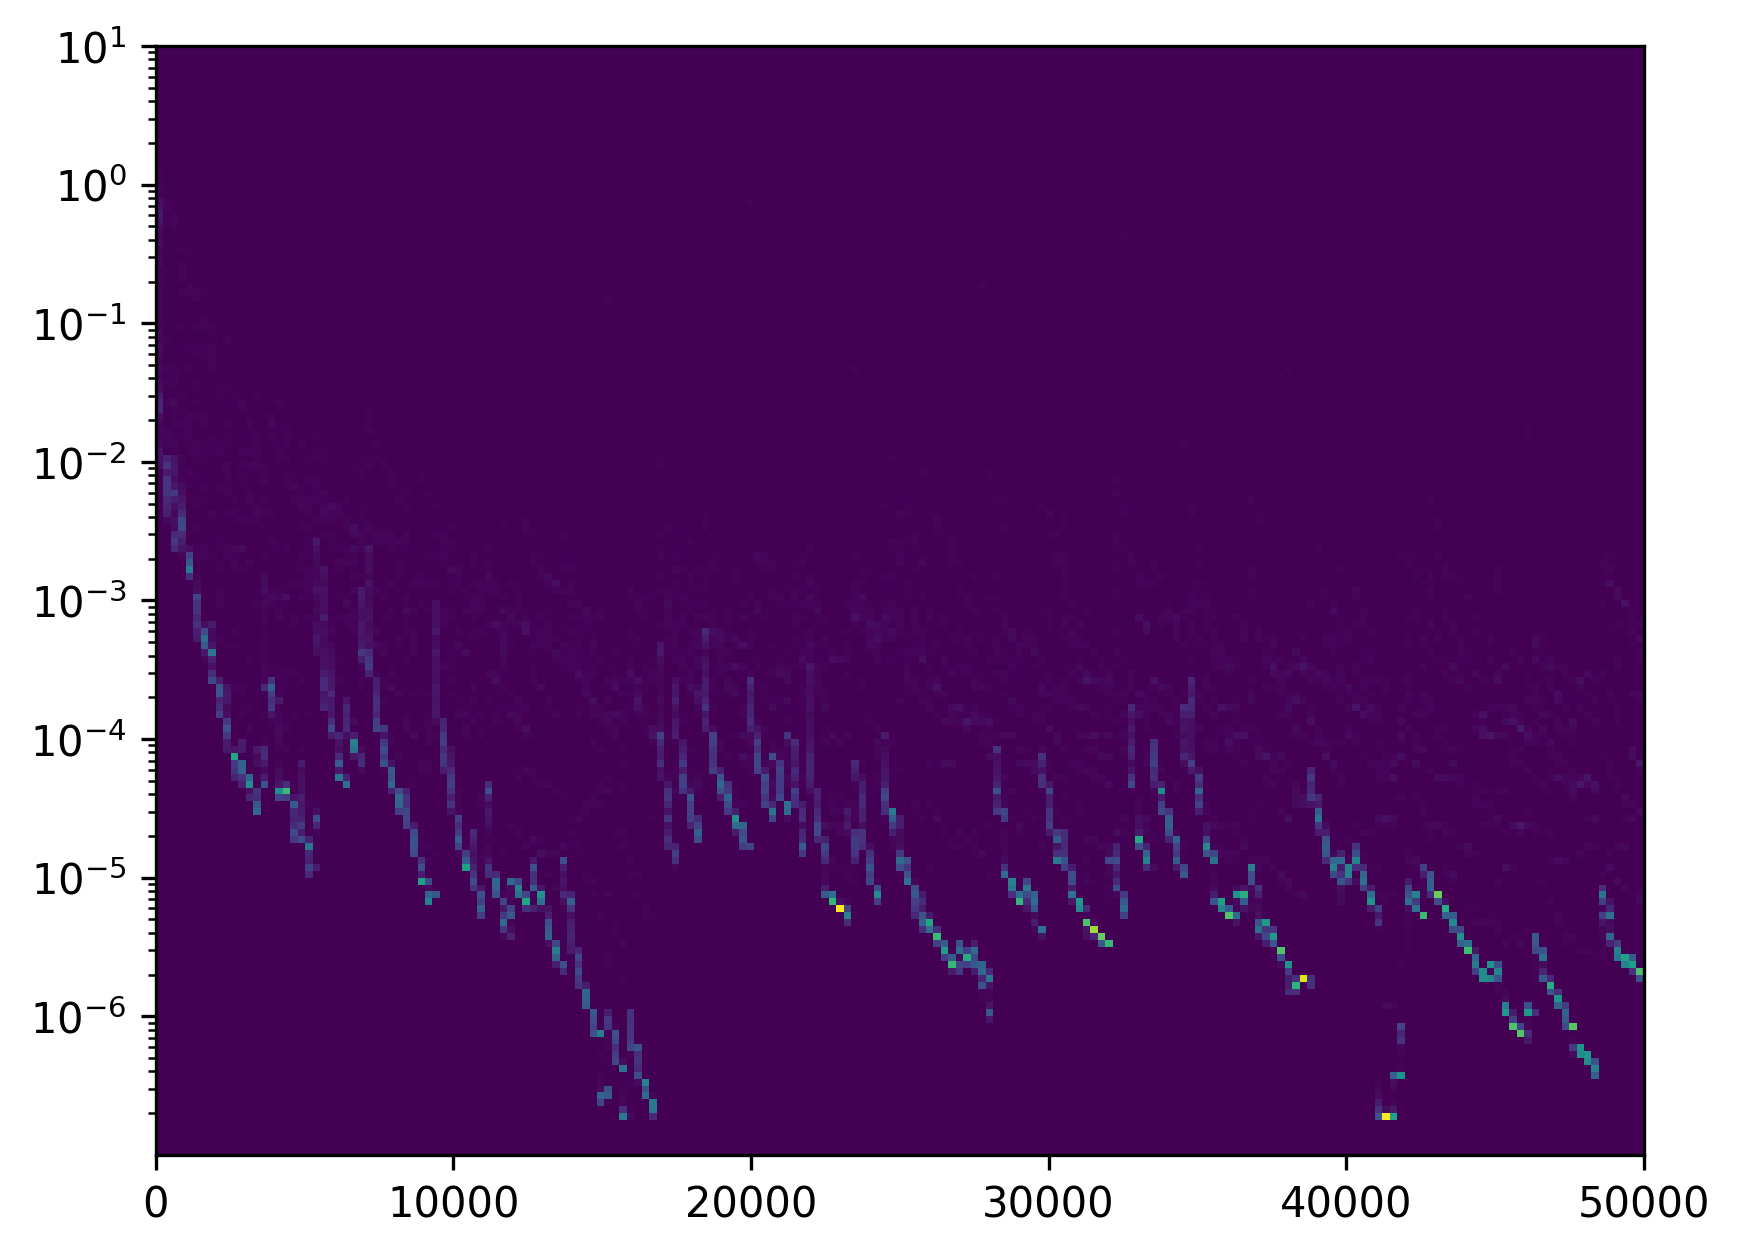

In [7]:
y_max = jnp.ceil(jnp.log10(losses).max()).astype(jnp.int32)
y_min = jnp.floor(jnp.log10(losses).min()).astype(jnp.int32)
plt.figure(dpi=300)
plt.hist2d(
    x=jnp.arange(losses.shape[0]), 
    y=losses, 
    bins=[
        jnp.linspace(0, losses.shape[0], 200),
        jnp.logspace(y_min, y_max, (y_max-y_min)*20+1)
    ],
    # norm=LogNorm(),
)
# plt.plot(jnp.arange(losses.shape[0]), losses, ',', alpha=.5)
plt.xlim(0, losses.shape[0])
plt.yscale('log')
plt.show()

# Compare to other decoders

In [8]:
data_key = random.key(42)

In [9]:
def get_data(
    data_key,
    batch_size: int,
    parity_info: tuple[jnp.ndarray],
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None, None),
        out_axes=0
    )(data_key[:-1], ERROR_PROBS, parity_info)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    print(errors.shape)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    recovery: jnp.ndarray,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

In [10]:
imgs, syndromes, logicals, data_key = get_data(
    data_key, 
    batch_size=1_000_000, 
    parity_info=parity_info
)

(1000000, 2, 9)


NN-model decoder

In [11]:
nn_logicals = (nn.sigmoid(
    model.apply(model_params, imgs)
) > .5).astype(jnp.int32)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * nn_logicals[:, 0] + nn_logicals[:, 1]
nn_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

MWPM decoder

In [12]:
from pymatching import Matching

def deform_recovery_batch(
    recovery = jnp.ndarray,
):
    def _deform_recovery(
        recovery = jnp.ndarray,
    ):
        inv_transformations = jnp.array([
            [[1, 0], [0, 1]],  # I
            [[1, 1], [0, 1]],  # X-Y
            [[1, 0], [1, 1]],  # Y-Z
            [[0, 1], [1, 0]],  # X-Z
            [[1, 1], [1, 0]],  # X-Z-Y
            [[0, 1], [1, 1]],  # X-Y-Z
        ])

        recovery_deformed = vmap(
            lambda A, B, Di: jnp.dot(Di, jnp.stack([A, B])) % 2,
            in_axes=(0, 0, 0),
            out_axes=1
        )(
            recovery[0],
            recovery[1],
            inv_transformations[CODE_DEFORMATION]
        )

        return recovery_deformed
    
    return vmap(_deform_recovery)(recovery)

# Decodes the un-deformed surface code and then deforms the recovery operation
matcher = Matching(
    jnp.append(code.hx_original, code.hz_original, axis=1)
)
recovery = matcher.decode_batch(syndromes)
recovery = recovery.reshape((recovery.shape[0], 2, recovery.shape[1]//2))
recovery = deform_recovery_batch(recovery)
mwpm_logicals = logicals_of_recovery(recovery, parity_info)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * mwpm_logicals[:, 0] + mwpm_logicals[:, 1]
mwpm_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

Perfect maximum likelihood decoder

In [13]:
from perfect_maximum_likelihood_decoder import PMLD

perfect_decoder = PMLD(code, ERROR_PROBS, parity_info)
pml_logicals = perfect_decoder.decode_batch(syndromes)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * pml_logicals[:, 0] + pml_logicals[:, 1]
pml_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

### Compare

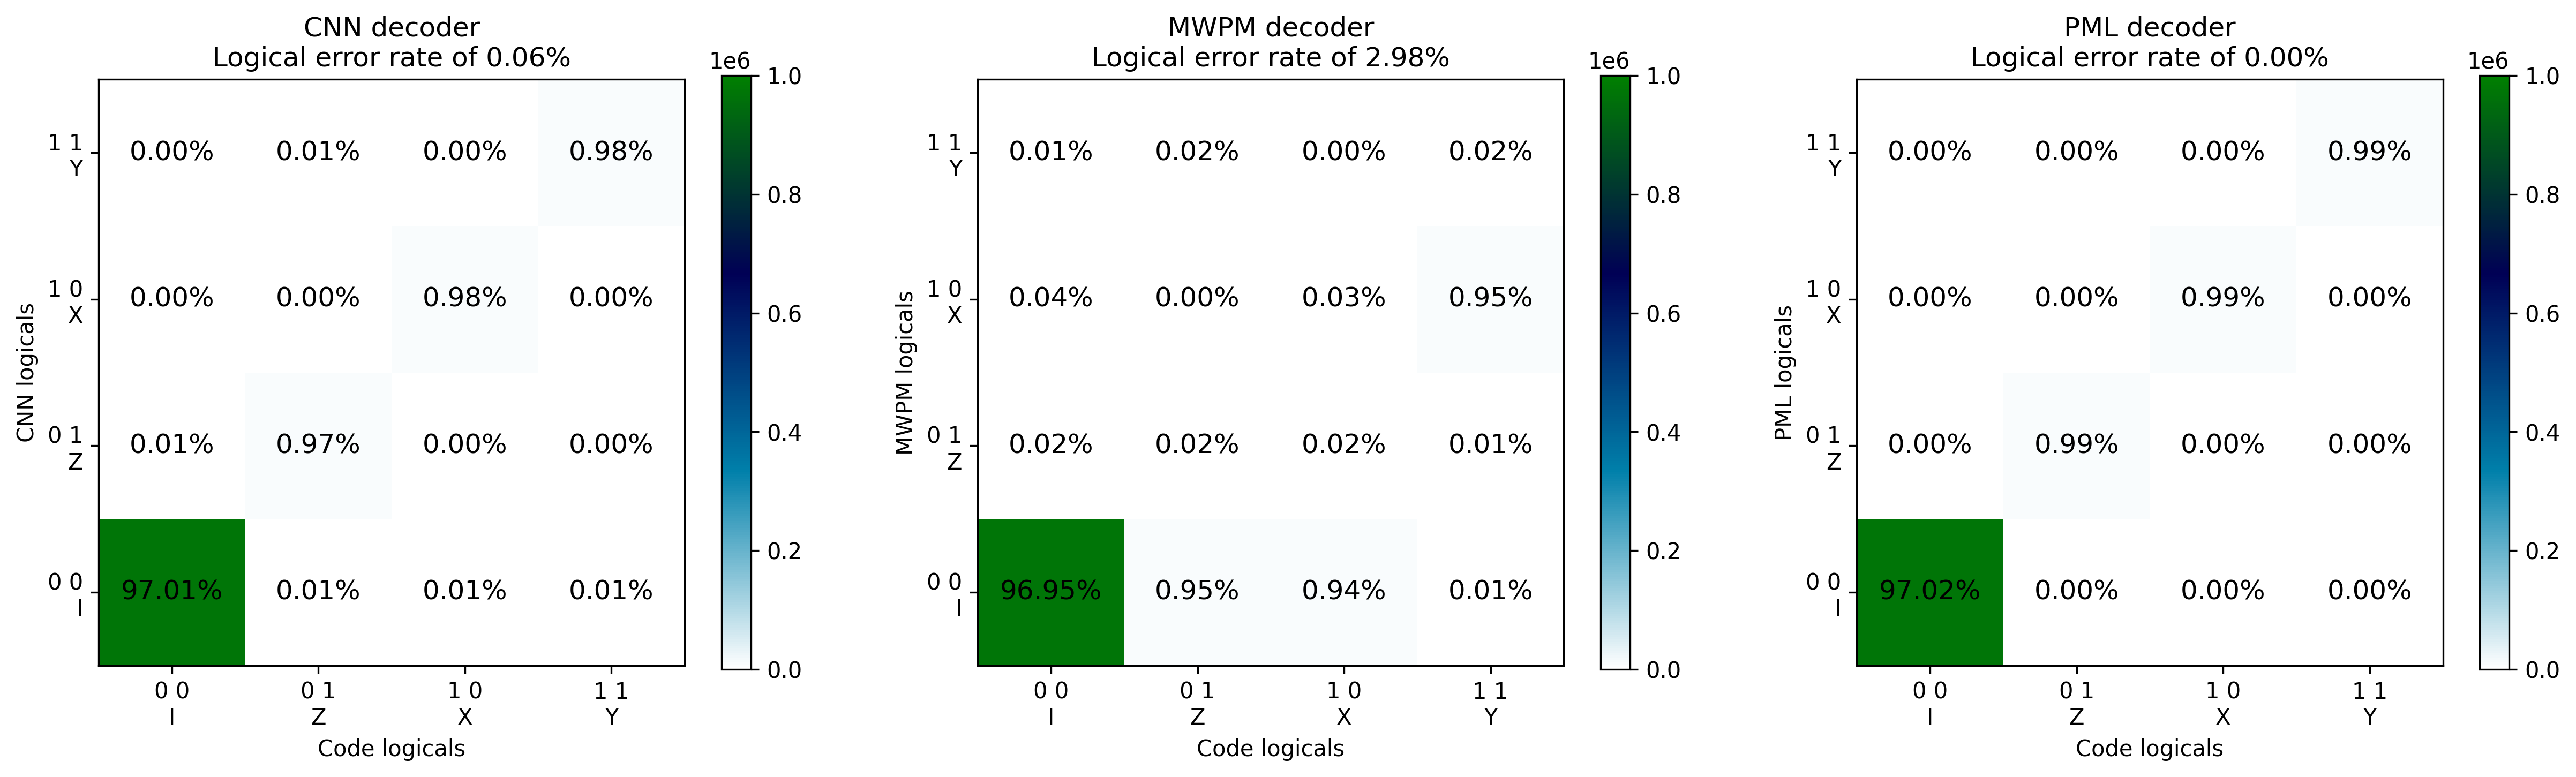

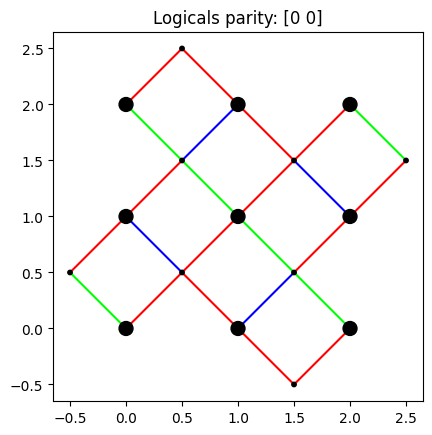

In [14]:
labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plot: tuple[plt.Figure, list[plt.Axes]] = plt.subplots(ncols=3)
fig, axs = plot
fig.set_figwidth(20)
fig.set_dpi(300)
for ax, hist, name in zip(
    axs,
    [nn_hist, mwpm_hist, pml_hist],
    ["CNN", "MWPM", "PML"]
):
    img = ax.imshow(
        hist, 
        origin='lower', 
        cmap='ocean_r',
        vmin=0,
        vmax=hist.sum(),
    )
    fig.colorbar(img)
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_xlabel('Code logicals')
    ax.set_ylabel(f'{name} logicals')
    for x, row in enumerate(jnp.array(hist).T):
        for y, count in enumerate(row):
            ax.text(x, y, f'{count/hist.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
    ax.set_title(f'{name} decoder\nLogical error rate of {1 - hist.diagonal().sum() / hist.sum():.2%}')
plt.show()

code.show(parity_info)

# Log results

In [ ]:
import json
from datetime import datetime

def log_output(
    log_file: str,
    entry: dict, 
):
    """Append the parameters and output as a single line in a log file."""
    with open(log_file, "a") as f:
        log_entry = json.dumps(entry)
        f.write(log_entry + "\n")

log_output("neural_network_decoder_training_results.txt",
    entry = {
        "Timestamp": datetime.timestamp(datetime.now()),
        "Hyper prameters": {
            "BATCH_SIZE": BATCH_SIZE,
            "TRAINING_BATCHES": TRAINING_BATCHES,
            "LEARNING_RATE": LEARNING_RATE,
            "TRANSITION_STEP": TRANSITION_STEP,
            "DECAY_RATE": DECAY_RATE,
            "CONV_LAYERS": CONV_LAYERS,
            "FC_LAYERS": FC_LAYERS,
            "SEED": SEED,
            "CODE_DISTANCE": CODE_DISTANCE,
            "CODE_DEFORMATION": CODE_DEFORMATION.tolist(),
            "ERROR_PROBS": ERROR_PROBS.tolist(),
        },
        "Result": {
            "Training_time": training_time,
            "NN error rate": (1 - nn_hist.diagonal().sum() / nn_hist.sum()).tolist(),
            "NN histogram": nn_hist.tolist(),
            "MWPM error rate": (1 - mwpm_hist.diagonal().sum() / mwpm_hist.sum()).tolist(),
            "MWPM histogram": mwpm_hist.tolist(),
            "PML error rate": (1 - pml_hist.diagonal().sum() / pml_hist.sum()).tolist(),
            "PML histogram": pml_hist.tolist(),
        },
        "Loss data (10k mean)": jnp.reshape(losses, (-1, 10_000)).mean(axis=1).tolist()
    }
)